<a href="https://colab.research.google.com/github/orhansonmeztr/Bio-LLMs/blob/main/SimCSE_sup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers -q
!pip install sacremoses -q
!pip install scann -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 16.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 58.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 88.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 71.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np 
import pandas as pd 
from platform import python_version
import os 
import sklearn
import json
from sklearn.decomposition import TruncatedSVD, PCA
import joblib
import math
import matplotlib.pyplot as plt
import scann
plt.style.use('ggplot')
from math import log2
import torch
from scipy.spatial.distance import cosine
from transformers import AutoModel, AutoTokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("sup-simcse-roberta-large")
model = AutoModel.from_pretrained("sup-simcse-roberta-large")

In [ ]:
dset="biotech"
f = open('vec_vectorized_biotech_patents_transformed_ols.json', "r")
data = json.loads(f.read())
data_abst = [data[i]['abstract'] for i in range(len(data))]
data_title = [data[i]['title'] for i in range(len(data))]

In [ ]:
def normalizer(x):     
    normalized_vector = x / np.linalg.norm(x)
    return normalized_vector

def sentence_encoder(data):
    vectors = []
    normalized_vectors = []
    for i in range(len(data)):
        inputs = tokenizer(data[i], padding=True, truncation=True, return_tensors="pt")

        # Get the embeddings
        with torch.no_grad():
            embeddings = model(**inputs, output_hidden_states=True, return_dict=True).pooler_output.detach().numpy()

        sentence_vector = embeddings[0]
        vectors.append(sentence_vector)
        normalized_vectors.append(normalizer(sentence_vector))

    vectors = np.squeeze(np.array(vectors))
    normalized_vectors = np.squeeze(np.array(normalized_vectors))

    return vectors, normalized_vectors

In [ ]:
abst_vectors, abst_vectors_norm = sentence_encoder(data_abst) 
title_vectors, title_vectors_norm = sentence_encoder(data_title) 

In [ ]:
print(abst_vectors_norm.shape, title_vectors_norm.shape)

In [ ]:
np.save('data_biotech_abstract_SimCSE_sup.npy',abst_vectors)
np.save('data_biotech_abstract_SimCSE_sup_norm.npy',abst_vectors_norm)

np.save('data_biotech_title_SimCSE_sup.npy',title_vectors)
np.save('data_biotech_title_SimCSE_sup_norm.npy',title_vectors_norm)

In [ ]:
# os.listdir('drive/MyDrive/transfer/patent')
os.chdir('/content/drive/MyDrive/vectors_via_biogpt_variants/')

In [ ]:
def vector_normalizer(x):     
    normalized_vector = x / np.linalg.norm(x)
    return normalized_vector

def apk(actual, predicted, k=10):
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0
    hits = []
    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)
        hits.append(num_hits)
    # if not actual:
    #     return 0.0
    # print(((hits)))
    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

def intersect(actual, predicted,k):
    return np.intersect1d(actual[:k], predicted[:k])

def hit_rate(actual, predicted,k):
    total = 0
    for i in range(len(actual)):
        intersection = intersect(actual[i], predicted[i],k)
        total = total + len(intersection)

    return total


def mean_reciprocal_rank(idx, k):
    rank = []
    for i in range(len(idx)):
        rank.append(np.where(idx[i][:k] == i)[0])

    elevated_rank = np.add(rank,1)
    elevated_rank = np.concatenate(elevated_rank)
    elevated_rank_len = len(elevated_rank)
    reciprocal_rank = np.divide(1,elevated_rank)
    reciprocal_rank_sum = np.sum(reciprocal_rank)
    # print('asfasfasfas',len(idx))
    # return reciprocal_rank_sum/elevated_rank_len
    return reciprocal_rank_sum/len(idx)    

def dcg_calc(similarity_scores, K):
    similarity_len = len(similarity_scores)
    total_dcg = []
    for similarities in similarity_scores:
        dcg = 0
        for k in range(1,K):
            rel_k = similarities[k-1]
            dcg += rel_k / log2(1 + k)
        total_dcg.append(dcg)
    return np.sum(total_dcg)/similarity_len    

def metrics_calculator(raw_idx, reduced_idx, k_values):
    k = k_values
    ap = []
    hit = []
    #mrr = []
    for i in k:
        ap.append( mapk(raw_idx, reduced_idx,i))
        hit.append( hit_rate(raw_idx, reduced_idx,i))
        # mrr.append(mean_reciprocal_rank(reduced_idx, i))
    return ap, hit #, mrr

In [ ]:
biotech_abstract_SimCSE_sup_norm = np.load('data_biotech_abstract_SimCSE_sup_norm.npy')
biotech_title_SimCSE_sup_norm = np.load('data_biotech_title_SimCSE_sup_norm.npy')
biotech_abstract_SimCSE_sup_norm.shape

(484, 1024)

In [ ]:
pca_abstract_SimCSE_sup= PCA().fit(biotech_abstract_SimCSE_sup_norm)
pca_var_SimCSE_sup = np.cumsum(pca_abstract_SimCSE_sup.explained_variance_ratio_)

In [ ]:
svd_abstract_SimCSE_sup = TruncatedSVD(n_iter= 25, n_components = 1024).fit(biotech_abstract_SimCSE_sup_norm)
svd_var_SimCSE_sup = np.cumsum(svd_abstract_SimCSE_sup.explained_variance_ratio_)

In [ ]:
print('PCA 100% :',np.where(np.array(pca_var_SimCSE_sup) >= 0.99)[0][0])
print('PCA 95% :',np.where(np.array(pca_var_SimCSE_sup) >= 0.95)[0][0])
print('PCA 90% :',np.where(np.array(pca_var_SimCSE_sup) >= 0.90)[0][0])

print('SVD 100% :',np.where(np.array(svd_var_SimCSE_sup) >= 0.99)[0][0])
print('SVD 95% :',np.where(np.array(svd_var_SimCSE_sup) >= 0.95)[0][0])
print('SVD 90% :',np.where(np.array(svd_var_SimCSE_sup) >= 0.90)[0][0])

PCA 100% : 116
PCA 95% : 59
PCA 90% : 37
SVD 100% : 117
SVD 95% : 59
SVD 90% : 38


In [ ]:
def pca_reducer(target_dimension, content, title):
    pca_name = '_pca_'+str(target_dimension)
    pca_ = PCA(n_components=target_dimension, random_state = 42, svd_solver = 'arpack')
    pca_.fit(content)
    content_vectors_pca = np.apply_along_axis(vector_normalizer,1,pca_.transform(content))
    title_vectors_pca = np.apply_along_axis(vector_normalizer,1,pca_.transform(title))

    inverse_content = pca_.inverse_transform(content_vectors_pca)
    inverse_title = pca_.inverse_transform(title_vectors_pca)

    np.save(dset + '_abst_vectors_norm'+pca_name,content_vectors_pca)
    np.save(dset + '_title_vectors_norm'+pca_name,title_vectors_pca)
#     np.save('drive/MyDrive/transfer/reduced_dim/inverse_content_vectors_norm'+pca_name, inverse_content)
#     np.save('drive/MyDrive/transfer/reduced_dim/inverse_title_vectors_norm'+pca_name, inverse_title)
    joblib.dump(pca_, pca_name)

def svd_reducer(target_dimension, content, title):
    svd_name = '_svd_'+str(target_dimension)
    svd_ = TruncatedSVD(n_iter= 25, n_components = target_dimension, random_state = 42 )
    svd_.fit(content)
    content_vectors_svd = np.apply_along_axis(vector_normalizer,1,svd_.transform(content))
    title_vectors_svd = np.apply_along_axis(vector_normalizer,1,svd_.transform(title))

    inverse_content = np.apply_along_axis(vector_normalizer,1,svd_.inverse_transform(content_vectors_svd))
    inverse_title = np.apply_along_axis(vector_normalizer,1,svd_.inverse_transform(title_vectors_svd))

    np.save(dset + '_abst_vectors_norm'+svd_name,content_vectors_svd)
    np.save(dset + '_title_vectors_norm'+svd_name,title_vectors_svd)
#     np.save('drive/MyDrive/transfer/reduced_dim/inverse_content_vectors_norm'+svd_name, inverse_content)
#     np.save('drive/MyDrive/transfer/reduced_dim/inverse_title_vectors_norm'+svd_name, inverse_title)
    joblib.dump(svd_, svd_name)

In [ ]:
pca_reducer(38, biotech_abstract_SimCSE_sup_norm, biotech_title_SimCSE_sup_norm)
pca_reducer(59, biotech_abstract_SimCSE_sup_norm, biotech_title_SimCSE_sup_norm)
pca_reducer(117, biotech_abstract_SimCSE_sup_norm, biotech_title_SimCSE_sup_norm)
pca_reducer(107, biotech_abstract_SimCSE_sup_norm, biotech_title_SimCSE_sup_norm)

svd_reducer(38, biotech_abstract_SimCSE_sup_norm, biotech_title_SimCSE_sup_norm)
svd_reducer(59, biotech_abstract_SimCSE_sup_norm, biotech_title_SimCSE_sup_norm)
svd_reducer(117, biotech_abstract_SimCSE_sup_norm, biotech_title_SimCSE_sup_norm)
svd_reducer(107, biotech_abstract_SimCSE_sup_norm, biotech_title_SimCSE_sup_norm)

In [ ]:
abstract_pca_38 = np.load(dset + '_abst_vectors_norm_pca_38.npy')
title_pca_38 = np.load(dset + '_title_vectors_norm_pca_38.npy')

abstract_pca_59 = np.load(dset + '_abst_vectors_norm_pca_59.npy')
title_pca_59 = np.load(dset + '_title_vectors_norm_pca_59.npy')

abstract_pca_117 = np.load(dset + '_abst_vectors_norm_pca_117.npy')
title_pca_117 = np.load(dset + '_title_vectors_norm_pca_117.npy')

abstract_pca_107 = np.load(dset + '_abst_vectors_norm_pca_107.npy')
title_pca_107 = np.load(dset + '_title_vectors_norm_pca_107.npy')


abstract_svd_38 = np.load(dset + '_abst_vectors_norm_svd_38.npy')
title_svd_38 = np.load(dset + '_title_vectors_norm_svd_38.npy')

abstract_svd_59 = np.load(dset + '_abst_vectors_norm_svd_59.npy')
title_svd_59 = np.load(dset + '_title_vectors_norm_svd_59.npy')

abstract_svd_117 = np.load(dset + '_abst_vectors_norm_svd_117.npy')
title_svd_117 = np.load(dset + '_title_vectors_norm_svd_117.npy')

abstract_svd_107 = np.load(dset + '_abst_vectors_norm_svd_107.npy')
title_svd_107 = np.load(dset + '_title_vectors_norm_svd_107.npy')

In [ ]:
searcher_raw = scann.scann_ops_pybind.builder(biotech_abstract_SimCSE_sup_norm, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()


searcher_pca_38 = scann.scann_ops_pybind.builder(abstract_pca_38, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_pca_59 = scann.scann_ops_pybind.builder(abstract_pca_59, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_pca_117 = scann.scann_ops_pybind.builder(abstract_pca_117, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_pca_107 = scann.scann_ops_pybind.builder(abstract_pca_107, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()


searcher_svd_38 = scann.scann_ops_pybind.builder(abstract_svd_38, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_svd_59 = scann.scann_ops_pybind.builder(abstract_svd_59, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_svd_117 = scann.scann_ops_pybind.builder(abstract_svd_117, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_svd_107 = scann.scann_ops_pybind.builder(abstract_svd_107, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

In [ ]:
raw_idx = []
reduced_idx_pca_38 = []
reduced_idx_svd_38 = []
reduced_idx_pca_59 = []
reduced_idx_svd_59 = []
reduced_idx_pca_117 = []
reduced_idx_svd_117 = []
reduced_idx_pca_107 = []
reduced_idx_svd_107 = []
for i in range(len(biotech_abstract_SimCSE_sup_norm)):
    raw_idx.append(searcher_raw.search(biotech_abstract_SimCSE_sup_norm[i])[0])
    reduced_idx_pca_38.append(searcher_pca_38.search(title_pca_38[i])[0])
    reduced_idx_svd_38.append(searcher_svd_38.search(title_svd_38[i])[0])
    reduced_idx_pca_59.append(searcher_pca_59.search(title_pca_59[i])[0])
    reduced_idx_svd_59.append(searcher_svd_59.search(title_svd_59[i])[0])
    reduced_idx_pca_117.append(searcher_pca_117.search(title_pca_117[i])[0])
    reduced_idx_svd_117.append(searcher_svd_117.search(title_svd_117[i])[0])
    reduced_idx_pca_107.append(searcher_pca_107.search(title_pca_107[i])[0])
    reduced_idx_svd_107.append(searcher_svd_107.search(title_svd_107[i])[0])

In [ ]:
k = [1,3,5,10,15,20,30]
ap_pca_38, hit_pca_38 = metrics_calculator(raw_idx,reduced_idx_pca_38, k )
ap_svd_38, hit_svd_38 = metrics_calculator(raw_idx,reduced_idx_svd_38, k )

ap_pca_59, hit_pca_59 = metrics_calculator(raw_idx,reduced_idx_pca_59, k )
ap_svd_59, hit_svd_59 = metrics_calculator(raw_idx,reduced_idx_svd_59, k )

ap_pca_117, hit_pca_117 = metrics_calculator(raw_idx,reduced_idx_pca_117, k )
ap_svd_117, hit_svd_117 = metrics_calculator(raw_idx,reduced_idx_svd_117, k )

ap_pca_107, hit_pca_107 = metrics_calculator(raw_idx,reduced_idx_pca_107, k )
ap_svd_107, hit_svd_107 = metrics_calculator(raw_idx,reduced_idx_svd_107, k )

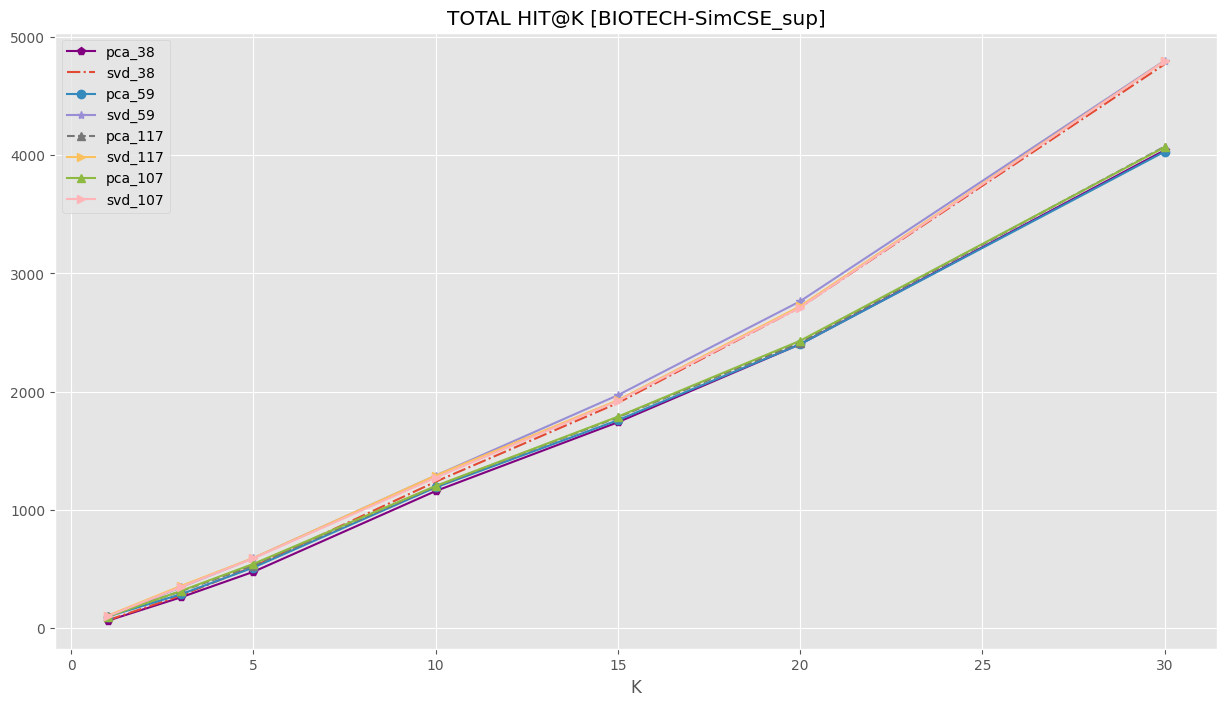

In [ ]:
# plt.subplot(1,4,2)
plt.figure(figsize =(15,8))
plt.plot(k,hit_pca_38, '-p', color = 'purple')
plt.plot(k,hit_svd_38, '-.')
plt.plot(k,hit_pca_59, '-o')
plt.plot(k,hit_svd_59, '-*')
plt.plot(k,hit_pca_117, '--^')
plt.plot(k,hit_svd_117, '>-')
plt.plot(k,hit_pca_107, '^-')
plt.plot(k,hit_svd_107, '->')

plt.title('TOTAL HIT@K [BIOTECH-SimCSE_sup]')
plt.legend(['pca_38','svd_38','pca_59','svd_59','pca_117','svd_117','pca_107','svd_107'])
plt.xlabel('K');

In [ ]:
print(hit_pca_38)
print(hit_pca_59)
print(hit_pca_117)
print(hit_pca_107)
print("-"*50)
print(hit_svd_38)
print(hit_svd_59)
print(hit_svd_117)
print(hit_svd_107)

[62, 259, 476, 1159, 1741, 2401, 4041]
[97, 285, 512, 1190, 1758, 2400, 4029]
[102, 310, 529, 1198, 1783, 2415, 4072]
[97, 313, 543, 1202, 1788, 2430, 4067]
--------------------------------------------------
[66, 274, 520, 1238, 1904, 2713, 4769]
[95, 344, 592, 1290, 1970, 2764, 4799]
[105, 355, 593, 1290, 1928, 2722, 4795]
[100, 346, 590, 1272, 1921, 2711, 4794]
